<a href="https://colab.research.google.com/github/arpitamangal/supply-chain-bullwhip-effect/blob/main/SupplyChainSimulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy

In [ ]:
import simpy
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
class DemandGenerator:
    def __init__(self):
        self.demand_probabilities = [0.15, 0.15, 0.7]
        self.demand_values = [100000, 150000, 200000]

    def generate_demand(self):
        demand = random.choices(self.demand_values, self.demand_probabilities)[0]
        return demand

#### Retailer

In [ ]:
class Retailer:
    def __init__(self, env, wholesaler):
        self.env = env
        self.wholesaler = wholesaler
        self.demand_generator = DemandGenerator()
        self.lead_time = random.randint(1, 4)
        self.incomingOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0         
        self.holding_cost = 0.5
        self.missed_order_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.action = env.process(self.run())


    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.missed_order_cost/(self.missed_order_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## placing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.incomingOrder = self.wholesaler.receive_order(order) 
        self.inventory += self.incomingOrder
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0) 

    def run(self):
        while True:
          self.receive_order()
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.missed_order_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()

    def receive_order(self):
      demand = self.demand_generator.generate_demand()
      self.demandList.append(demand)
      if self.inventory < demand:
          self.outgoingOrder = self.inventory
      else:
          self.outgoingOrder = demand
      self.inventory -= self.outgoingOrder
        
          


#### Wholesaler

In [ ]:
class Wholesaler:
    def __init__(self, env, distributor):
        self.env = env
        self.distributor = distributor
        self.lead_time = random.randint(1, 4)
        self.incomingOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0        
        self.holding_cost = 0.5
        self.missed_order_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.action = env.process(self.run())


    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.missed_order_cost/(self.missed_order_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## placing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.incomingOrder = self.distributor.receive_order(order) 
        self.inventory += self.incomingOrder
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0) 

    def run(self):
        while True:
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.missed_order_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()
          

    def receive_order(self, demand):
        self.demandList.append(demand)
        if self.inventory < demand:
            self.outgoingOrder = self.inventory
        else:
            self.outgoingOrder = demand
        self.inventory -= self.outgoingOrder  
        return self.outgoingOrder


#### Distributor

In [ ]:
class Distributor:
    def __init__(self, env, factory):
        self.env = env
        self.factory = factory
        self.lead_time = random.randint(1, 4)
        self.incomingOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0        
        self.holding_cost = 0.5
        self.missed_order_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.action = env.process(self.run())

    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.missed_order_cost/(self.missed_order_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## placing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.incomingOrder = self.factory.receive_order(order)
        self.inventory += self.incomingOrder
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0)
        

    def run(self):
        while True:
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.missed_order_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()
          
    def receive_order(self, demand):
      self.demandList.append(demand)
      if self.inventory < demand:
          self.outgoingOrder = self.inventory
      else:
          self.outgoingOrder = demand
      self.inventory -= self.outgoingOrder  
      return self.outgoingOrder

#### Factory

In [ ]:
class Factory:
    def __init__(self, env):
        self.env = env
        self.lead_time = random.randint(1, 4)
        self.productionOrder = 0
        self.outgoingOrder = 0
        self.inventory = 0        
        self.holding_cost = 0.5
        self.missed_order_cost = 1
        self.costs = []
        self.demandList = []
        self.optimalQtyList = []
        self.OrderList = []
        self.inventoryList  = []
        self.action = env.process(self.run())

    def cal_optimal_quantity(self):
      ## Use new vendor model to calculate optimal quantity
      mu = np.mean(self.demandList)
      sigma = np.std(self.demandList)
      criticalRatio = self.missed_order_cost/(self.missed_order_cost+self.holding_cost)
      optimalQuantity = round(sigma*norm.ppf(criticalRatio) + mu,0)
      return optimalQuantity

    def place_order(self):
      ## producing the optimal order
      optimalQuantity = self.cal_optimal_quantity()
      self.optimalQtyList.append(optimalQuantity)
      if self.inventory < optimalQuantity:
        order = optimalQuantity - self.inventory
        self.OrderList.append(order)
        self.inventory += order
        self.inventoryList.append(self.inventory)
      else: self.OrderList.append(0)
        
    def run(self):
        while True:
          if self.inventory >= 0:
            self.costs.append(self.inventory*self.holding_cost)
          else:
            self.costs.append(abs(self.inventory*self.missed_order_cost))
          yield self.env.timeout(self.lead_time)
          self.place_order()
          
    def receive_order(self, demand):
      self.demandList.append(demand)
      if self.inventory < demand:
          self.outgoingOrder = self.inventory
      else:
          self.outgoingOrder = demand
      self.inventory -= self.outgoingOrder  
      return self.outgoingOrder

#### Simulation

In [ ]:
def run_simulation():
    env = simpy.Environment()

    factory = Factory(env)
    distributor = Distributor(env, factory)
    wholesaler = Wholesaler(env, distributor)
    retailer = Retailer(env, wholesaler)

    env.process(retailer.run())
    env.process(wholesaler.run())
    env.process(distributor.run())
    env.process(factory.run())

    env.run(until=50)  # Run the simulation for 50 time steps

    print("Retailer demandList:", retailer.demandList)
    print("Wholesaler demandList:", wholesaler.demandList)
    print("Distributor demandList:", distributor.demandList)
    print("Factory demandList:", factory.demandList)

    print("Retailer optimalQtyList:", retailer.optimalQtyList)
    print("Wholesaler optimalQtyList:", wholesaler.optimalQtyList)
    print("Distributor optimalQtyList:", distributor.optimalQtyList)
    print("Factory optimalQtyList:", factory.optimalQtyList)

    print("Retailer OrderList:", retailer.OrderList)
    print("Wholesaler OrderList:", wholesaler.OrderList)
    print("Distributor OrderList:", distributor.OrderList)
    print("Factory OrderList:", factory.OrderList)

    print("Retailer inventoryList:", retailer.inventoryList)
    print("Wholesaler inventoryList:", wholesaler.inventoryList)
    print("Distributor inventoryList:", distributor.inventoryList)
    print("Factory inventoryList:", factory.inventoryList)

    print("Retailer costs:", retailer.costs)
    print("Wholesaler costs:", wholesaler.costs)
    print("Distributor costs:", distributor.costs)
    print("Factory costs:", factory.costs)

    # Plot weekly costs
    plt.plot(retailer.costs, label='Retailer')
    plt.plot(wholesaler.costs, label='Wholesaler')
    plt.plot(distributor.costs, label='Distributor')
    plt.plot(factory.costs, label='Factory')
    plt.xlabel('Time Steps')
    plt.ylabel('Weekly Costs ($)')
    plt.title('Weekly Costs of Each Entity')
    plt.legend()
    plt.show()

    plt.plot(retailer.inventoryList, label='Retailer')
    plt.plot(wholesaler.inventoryList, label='Wholesaler')
    plt.plot(distributor.inventoryList, label='Distributor')
    plt.plot(factory.inventoryList, label='Factory')
    plt.xlabel('Time Steps')
    plt.ylabel('Weekly Inventory (Qty)')
    plt.title('Weekly Inventory of Each Entity')
    plt.legend()
    plt.show()


    plt.plot(retailer.OrderList, label='Retailer')
    plt.plot(wholesaler.OrderList, label='Wholesaler')
    plt.plot(distributor.OrderList, label='Distributor')
    plt.plot(factory.OrderList, label='Factory')
    plt.xlabel('Time Steps')
    plt.ylabel('Weekly Order (Qty)')
    plt.title('Weekly Order of Each Entity')
    plt.legend()
    plt.show()


Retailer demandList: [200000, 150000, 200000, 100000, 200000, 200000, 200000, 100000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 100000, 100000, 200000, 100000, 200000, 200000, 200000, 200000, 200000, 200000, 200000, 150000, 200000, 100000, 200000, 200000, 200000, 200000, 200000]
Wholesaler demandList: [185768.0, 193486.0, 180357.0, 187229.0, 191449.0, 194259.0, 187206.0, 190129.0, 192363.0, 194115.0, 195517.0, 196659.0, 197603.0, 198392.0, 195098.0, 112763.0, 192947.0, 189952.0, 191120.0, 192155.0, 193077.0, 193902.0, 194645.0, 195315.0, 195922.0, 194698.0, 195282.0, 129903.0, 194015.0, 194578.0, 195098.0, 195579.0]
Distributor demandList: [191289.0, 191289.0, 188724.0, 190851.0, 191463.0, 467.0, 192677.0, 3120.0, 193879.0, 14842.0, 195557.0, 23086.0, 195576.0, 27192.0, 195758.0, 30212.0, 196284.0, 32782.0, 195684.0, 33670.0, 195892.0, 35093.0]
Factory demandList: [191289.0, 191289.0, 191289.0, 188390.0, 190892.0, 189557.0, 179037.0, 172471.0, 168384.0, 165546.0, 163502.0

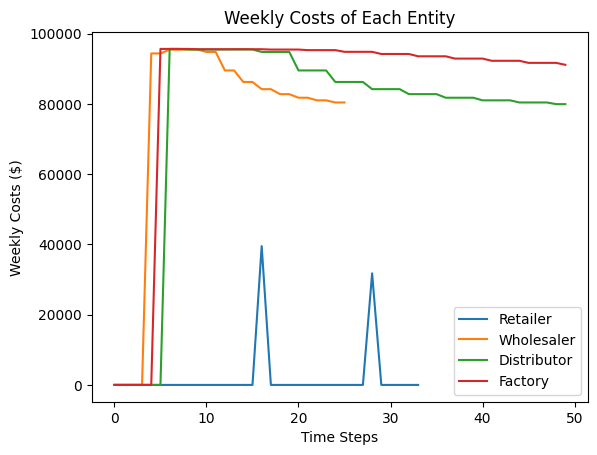

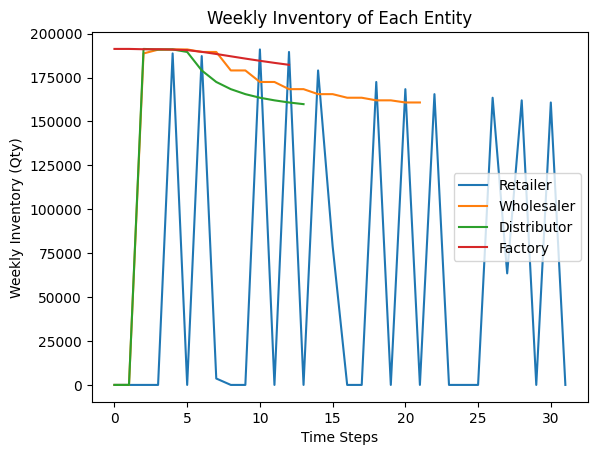

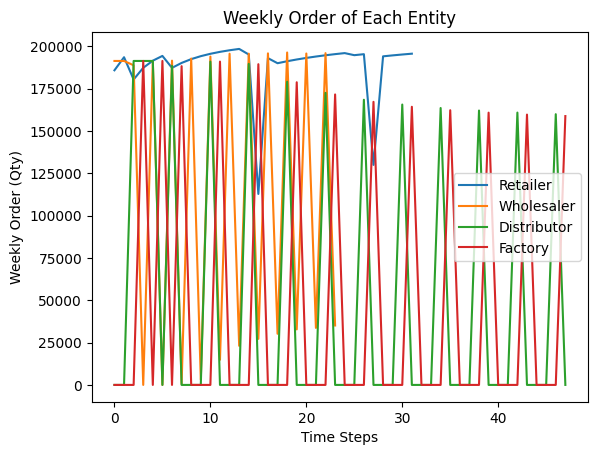

In [ ]:
run_simulation()